Ce projet est réalisé par Sarah BEHANZIN et Amine BELGACEM dans le cadre de notre cours de Deep Learning.

# Librairies nécessaires

In [212]:
#Librairies de base
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd   
import seaborn as sns 

#Librairies Scikit Learn
from sklearn.model_selection import train_test_split, KFold


#Librairies keras 
import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.datasets.mnist import load_data
from keras.datasets import mnist
from keras.layers import Conv2D, MaxPooling2D ,Dropout, Dense, Flatten, InputLayer
from keras.models import Sequential , Model
from keras.callbacks import TensorBoard
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical

## Introduction

Dans le cadre de ce projet, nous devons réaliser un algorithme de Deep Learning nous permettant de pouvoir reconnaître et déchiffrer les numéros écrits sur les images issus de la base de données MNIST.

## Importation des données 

On commence par importer les données.

On a récuperé les fichiers test et train de MNIST via la librairie keras. On peut récuperer la base de données via la fonction load_data()

In [213]:
#Chargement de la base de données
(train_X, train_y), (test_X, test_y) = mnist.load_data()

## Organisation des données 

Notre base de données est déjà decoupée en plusieurs parties : 
- train_y va contenir la colonne contenant tous les labels de la base de données d'apprentissage.
- train_X va contenir tout le reste, c'est à dire les pixels des images de la base de données d'apprentissage.
- test_X va contenir la colonne contenant tous les labels de la base de données de test.
- test_y va contenir tout le reste, c'est à dire les pixels des images de la base de données de test.

On regarde la répartition de notre base de donnée train_X et test_X

In [214]:
train_X.shape

(60000, 28, 28)

In [215]:
test_X.shape

(10000, 28, 28)

On visualise si nous avons une bonne répartition des labels dans notre jeu de données.

Cette vérification est primordiale, car si on a une répartition vraiment déséquillibrée des labels dans notre base d'apprentissage et de test, nous ne pourrons pas bien entrainer notre modèle et donc cela nous donnera une mauvaise prédiction.

C:\Users\Belgacem\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


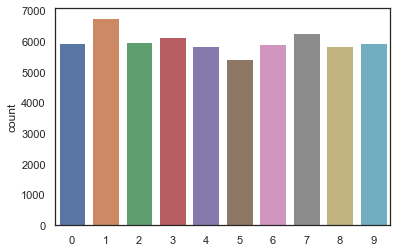

In [216]:
#visualisation de la repartition des labels de la base d'apprentissage
sns.set(style='white', context='notebook', palette='deep')
ax = sns.countplot(train_y)

C:\Users\Belgacem\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


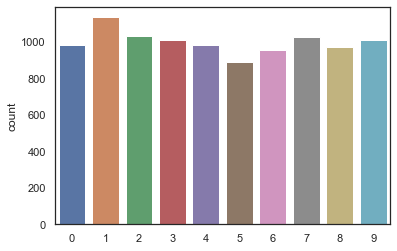

In [217]:
#visualisation de la repartition des labels de la base de test
sns.set(style='white', context='notebook', palette='deep')
ax = sns.countplot(test_y)

On normalise maintenant nos données pour avoir les valeurs de nos pixels dans le code RVB, entre 0 et 255.

In [218]:
train_X = train_X.astype('float32') / 255
test_X  =  test_X.astype('float32') / 255

On transforme nos labels en variable catégorielles grâce à la fonction to_categorical(). Cette fonction va convertir notre chiffre correspondant au label en un vecteur binaire de taille 10 (car nous avons des chiffres allant de 0 à 9).

Cela va nous permettre d'optimiser notre réseau de neuronnes.

In [219]:
train_y = to_categorical(train_y)
test_y = to_categorical(test_y)

## Création du modèle par réseau multicouche simple

In [220]:
train_X.shape

(60000, 28, 28)

Pour notre réseau de neuronnes simple, on doit applatire notre données qui est sous la forme ci-dessus. Et pour pouvoir bien l'implémenter dans notre  réseau de couche, on doit le mettre sous la forme (..,784)

In [221]:
train_X = train_X.reshape(train_X.shape[0], 784)
test_X = test_X.reshape(test_X.shape[0], 784)

In [222]:
train_X.shape

(60000, 784)

### Modèle de réseau multicouche 

On initialise donc notre modèle en 3 couches : 
- la première représente la couche d'entrée qui doit avoir en paramètres le nombre de colonnes
- la deuxième représente ce que l'on appelle la couche cachée
- la dernière représente la couche de sortie qui doit avoir en paramètres le nombre de classes que nous avons à prédire

In [223]:
#implémentation des différentes couches
model = Sequential([
    Dense(784, input_dim=784,
          kernel_initializer ='normal', 
          activation = 'relu'), #Input Layer
    Dense(392,
          kernel_initializer ='normal', 
          activation = 'relu'), #Hidden Layer     
    Dense(10,
          kernel_initializer ='normal', 
          activation = 'softmax')#Output Layer 
])

On utilise l'optimiseur Adam et la fonction de perte d'entropie croisée catégorielle.

Nous prenons comme métrique d'analyse la précision.

In [224]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam', 
              metrics=['accuracy'])

On peut maintenant entraîner notre modèle.

In [225]:
model.fit(x=train_X,
          y=train_y,
          validation_data=(test_X, test_y),
          epochs=25,
          batch_size=32, 
          verbose=0)

In [226]:
scores = model.evaluate(test_X, test_y)
print('Notre modèle à une précision de ',
      '%.3f' % (scores[1] * 100.0) ,
      '% sur l\'ensemble de test ')

313/313 [==============================] - 2s 5ms/step - loss: 0.1555 - accuracy: 0.9817
Notre modèle à une précision de  98.170 % sur l'ensemble de test 


### Modèle de réseau multicouche avec 3-Fold validation croisée

Nous créeons une fonction de notre modèle pour faciliter l'implémentation dans le code.

In [227]:
#Création de la fonction du modèle 
def fonction_model():
    model = Sequential([
        Dense(784, input_dim=784,
              kernel_initializer ='normal', 
              activation = 'relu'), #Input Layer
        Dense(392,
              kernel_initializer ='normal', 
              activation = 'relu'), #Hidden Layer     
        Dense(10,
              kernel_initializer ='normal', 
              activation = 'softmax')#Output Layer 
    ])
    model.compile(loss='categorical_crossentropy',
              optimizer='adam', 
              metrics=['accuracy'])
    return model

Nous allons réaliser une opération de Kfold avec 3 splits.

In [230]:
#Initialisation de la méthode des K-Folds
kfold = KFold(3, shuffle=True, random_state=1)

Nous allons maintenant créer une boucle qui va permettre d'apprendre notre modèle sur les 3 divisions que fait notre Kfold.

Sur chaque itération de la boucle, cela va diviser les bases de données d'apprentissages et de tests de manières différentes pour permettre un meilleur apprentissage du modèle.

Le chargement de cette cellule prends un certain temps.

In [231]:
#Entrainement du modèle avec la méthode des K-Folds
hist_NN_f= list()
acc_NN_f = list()
loss_NN_f = list()
for train_i, test_i in kfold.split(train_X):
    NN_k_trainX, NN_k_trainY, NN_k_testX, NN_k_testY = train_X[train_i],train_y[train_i],train_X[test_i], train_y[test_i]
    
    model_Kfold = fonction_model()
    
    hist = model_Kfold.fit(NN_k_trainX, 
                     NN_k_trainY, 
                     epochs=10, 
                     batch_size=32, 
                     validation_data=(NN_k_testX, NN_k_testY), 
                     verbose=0)
    
    loss_NN,acc_NN = model_Kfold.evaluate(NN_k_testX, 
                              NN_k_testY, 
                              verbose=0)
    
    acc_NN_f.append('%.3f' % (acc_NN * 100.0))
    loss_NN_f.append('%.3f'% (loss_NN * 100.0))
    hist_NN_f.append(hist)

In [232]:
#Précision du modèle sur les différentes divisions de la base de données
acc_NN_f

['97.655', '97.265', '98.185']

In [233]:
res_acc_NN_f= (float(acc_NN_f[0])+float(acc_NN_f[1])+float(acc_NN_f[2]))/len(acc_NN_f)
print('Notre modèle à une précision de ',
      '%.3f' % (res_acc_NN_f) ,
      '% sur l\'ensemble de test ')

Notre modèle à une précision de  97.702 % sur l'ensemble de test 


Les lignes de codes ci-dessous vont nous permettre de faire des prédictions et les verifier visuellement.

On crée une variable image_index qui représente un chiffre aléatoire entre 1 et 10 000.

Le nombre prédit par le modèle de NN avec les Kfold est 2
Le nombre prédit par le modèle de NN normal est 2


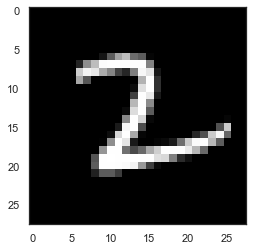

In [234]:
from random import *

liste = []
for i in range(10000):
    liste.append(randint(0, 1000) )

shuffle(liste)
im_index = choice(liste)

plt.imshow(test_X[im_index].reshape(28, 28),cmap='gist_gray')
pred_kfold = model_Kfold.predict(test_X[im_index].reshape(1, 784))
print('Le nombre prédit par le modèle de NN avec les Kfold est',pred_kfold.argmax())
pred = model.predict(test_X[im_index].reshape(1, 784))
print('Le nombre prédit par le modèle de NN normal est',pred.argmax())

## Création du modèle par réseau multicouche avec Convolution

### Modèle de réseau multicouche avec convolution

On va maintenant créer le modèle. 

On commence par initialiser le modèle : 

Le modèle que nous utilisons est le Sequential(). Il permet de regrouper et rassembler plusieurs couches. 


In [235]:
model_conv = Sequential()

On définit maintenant le modèle.

Notre modèle de réseau de neurone convolutif aura, pour commencer, une seule couche de taille (3,3) avec 32 filtres.

Avec la fonction MaxPooling2D(), cela va nous retourner la couche de regroupement maximum. Cette fonction va réaliser un échantillonnage de format 2x2 sur toute notre image et va retourner la valeur maximale du pixel compris dans l'entrée qu'il échantillonne. 

Flatten() va nous permettre d'applatir les filtres pour fournir des caractéristiques à notre classificateur. 

La dernière ligne représente la couche de sortie. Comme nous avons une tâche de classification de 10 classes, on doit avoir une couche avec 10 sorties pour pouvoir prédire les images par rapport à leurs labels.

In [236]:
#implémentation des différentes couches
model_conv.add(Conv2D(32, (3, 3), 
                  activation='relu', 
                  kernel_initializer='he_uniform', 
                  input_shape=(28, 28, 1)))

model_conv.add(MaxPooling2D((2, 2)))
model_conv.add(Flatten())

model_conv.add(Dense(100, 
                 activation='relu', 
                 kernel_initializer='he_uniform'))

model_conv.add(Dense(10, activation='softmax'))

On utilise l'optimiseur Adam et la fonction de perte d'entropie croisée catégorielle.

Nous prenons comme métrique d'analyse la précision.

In [237]:
#Compilation du modèle
model_conv.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Pour pouvoir augmenter la précision de notre réseau de neuronne avec convolution, on doit tout d'abord mettre nos données sous la bonne forme. On a 784 colonnes et on doit les mettre sous forme de matrice 28x28 correspondant à une image de 28x28 pixels.

In [238]:
#Mise en forme des données pour le réseau de neuronnes avec convolution
train_X = train_X.reshape((train_X.shape[0], 28, 28, 1))
test_X = test_X.reshape((test_X.shape[0], 28, 28, 1))

Nous pouvons commencer à entrainer le modèle.

In [239]:
#On entraine le modèle
model_conv.fit(x=train_X,
           y=train_y, 
           epochs=25, 
           batch_size=32, 
           validation_data=(test_X, test_y), 
           verbose=0)

In [240]:
#Visualisation de la précision et de la perte de notre modèle
loss_model, acc_model = model_conv.evaluate(x=test_X,y=test_y)
print('Notre modèle à une précision de ',
      '%.3f' % (acc_model * 100.0) ,
      '% sur l\'ensemble de test ')

313/313 [==============================] - 2s 7ms/step - loss: 0.1018 - accuracy: 0.9841
Notre modèle à une précision de  98.410 % sur l'ensemble de test 


On observe une augmentation de la précision de la prédiction.

### Modèle de réseau multicouche avec convolution avec 3-fold validation croisée

On va maintenant réaliser une validation croisée avec 3-Fold

Pour faciliter et rendre le code plus clair, on crée une fonction qui va retourner notre modèle.

In [241]:
#Création de la fonction du modèle
def fonction_model_conv():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), 
                    activation='relu', 
                    kernel_initializer='he_uniform',
                    input_shape=(28, 28, 1)))
    
    model.add(MaxPooling2D((2,2)))
    
    model.add(Flatten())
    
    model.add(Dense(100, 
                    activation='relu', 
                    kernel_initializer='he_uniform'))
    
    model.add(Dense(10, 
                    activation='softmax'))
    
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

Nous allons réaliser une opération de Kfold avec 3 splits.

In [242]:
#Initialisation de la méthode des K-Folds
kfold = KFold(3, shuffle=True, random_state=1)

Nous allons ré utiliser le même code que nous avons utilisé dans la partie précédente pour réaliser notre algorithme des K-Folds

Le chargement de cette cellule prends un certain temps.

In [243]:
#Entrainement du modèle avec la méthode des K-Folds
hist_f= list()
acc_f = list()
loss_f = list()
for train_i, test_i in kfold.split(train_X):
    k_trainX, k_trainY, k_testX, k_testY = train_X[train_i], train_y[train_i], train_X[test_i],  train_y[test_i]
    
    model_conv_Kfold = fonction_model_conv()
    
    hist = model_conv_Kfold.fit(k_trainX, 
                     k_trainY, 
                     epochs=10, 
                     batch_size=32, 
                     validation_data=(k_testX, k_testY), 
                     verbose=0)
    
    loss,acc = model_conv_Kfold.evaluate(k_testX, 
                              k_testY, 
                              verbose=0)
    
    acc_f.append('%.3f' % (acc * 100.0))
    loss_f.append('%.3f' % (loss * 100.0))
    hist_f.append(hist)

In [244]:
#Précision du modèle sur les différentes divisions de la base de données
acc_f

['98.135', '98.225', '98.300']

In [245]:
res_acc_f= (float(acc_f[0])+float(acc_f[1])+float(acc_f[2]))/len(acc_f)
print('Notre modèle à une précision de ',
      '%.3f' % (res_acc_f) ,
      '% sur l\'ensemble de test ')

Notre modèle à une précision de  98.220 % sur l'ensemble de test 


<ipython-input-246-972b705fec35>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2, 1, 1)


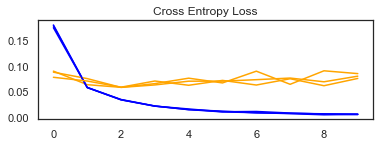

In [246]:
#On affiche le graphique correspondant à l'évolution de la perte du modèle lors de l'apprentissage.

for i in range(len(hist_f)):
    #1er graphique
    plt.subplot(2, 1, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(hist_f[i].history['loss'], color='blue', label='train')
    plt.plot(hist_f[i].history['val_loss'], color='orange', label='test')
plt.show()

<ipython-input-247-9c3bf63fd69c>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2, 1, 2)


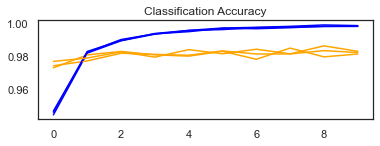

In [247]:
#On affiche le graphique correspondant à l'évolution de la précision du modèle lors de l'apprentissage.

for i in range(len(hist_f)): 
    #2ème graphique
    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(hist_f[i].history['accuracy'], color='blue', label='train')
    plt.plot(hist_f[i].history['val_accuracy'], color='orange', label='test')
plt.show()

Nous allons ré utiliser les lignes de codes nous permettant de prédire et vérifier visuellement la prédiction et les utiliser avec notre modèle avec les 3-Folds. 

Nous allons comparer les prédiction des deux modèles  en utilisant le même indice d'image.

Le nombre prédit par le modèle de CNN normal est 3
Le nombre prédit par le modèle de CNN avec les Kfold est 3


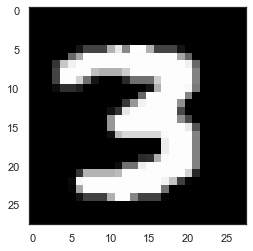

In [249]:
from random import *

liste = []
for i in range(10000):
    liste.append(randint(0, 1000) )

shuffle(liste)
image_index_2 = choice(liste)

plt.imshow(test_X[image_index_2].reshape(28, 28),cmap='gist_gray')
pred_conv_Kfold = model_conv_Kfold.predict(test_X[image_index_2].reshape(1, 28, 28, 1))
pred_conv = model_conv.predict(test_X[image_index_2].reshape(1, 28, 28, 1))
print('Le nombre prédit par le modèle de CNN normal est',pred_conv.argmax())
print('Le nombre prédit par le modèle de CNN avec les Kfold est',pred_conv_Kfold.argmax())

## Conclusion

Nous pouvons conclure que notre modèle de réseau multicouches avec convolution a une meilleur précision que le réseau multicouches normal. 

En effet, le principe de convolution permets de mieux déterminer les différentes caractéristiques.